In [1]:
import copy
import os

import numpy as np

import coloradar_dataset_lib as ct
import coloradar_cuda_lib as cu  # REMOVE THIS LINE IF YOUR IMAGE DOES NOT SUPPORT CUDA
from scripts import demo_tools as demo

### Initialize Dataset

In [2]:
# no need to change anything here
COLORADAR_PATH = '/data/coloradar'
try:
    dataset = ct.ColoradarPlusDataset(COLORADAR_PATH)
except RuntimeError:
    dataset = ct.ColoradarDataset(COLORADAR_PATH)

print('Detected runs:', ', '.join(dataset.list_runs()))

Detected runs: ec_hallways_run4, ec_hallways_run2


#### Initialize cascade radar config

In [3]:
radar_config = dataset.cascade_config()
print('Max radar range: ', radar_config.max_range())

Max radar range:  7.590000152587891


#### Create a run object

In [4]:
run = dataset.get_run('ec_hallways_run2')
print(f'Number of radar frames in run {run.name()}:', len(run.cascade_timestamps()))

Number of radar frames in run ec_hallways_run2: 1396


#### Read a single radar scan as a datacube

In [5]:
cascade_cube = run.get_cascade_datacube(100)
print('Flat datacube size:', cascade_cube.shape)


Warning! Frames are not indexed from 0 in directory
'/data/coloradar/kitti/ec_hallways_run2/cascade/adc_samples/data'
(first detected frame index: 1)

Flat datacube size: (1572864,)


#### Convert datacube to heatmap (ONLY WORKS WITH coloradar_cuda_lib)

In [6]:
cuda_processor = cu.RadarProcessor(radar_config)
heatmap_from_datacube = cuda_processor.cube_to_heatmap(
    cascade_cube, 
    apply_collapse_doppler=True, 
    remove_antenna_coupling=True, 
    apply_phase_frequency_calib=True
)
print('Flat heatmap size:', heatmap_from_datacube.shape)

Flat heatmap size: (1048576,)


#### Compare to the original heatmap in the dataset
The original heatmaps were computed from the datacubes when the dataset was released. 
The differences are likely coming from the calibration matrices that were updated and replaced multiple times in the dataset.

In [7]:
heatmap_original = run.get_cascade_heatmap(100)
print('Flat original heatmap size:', heatmap_original.shape)

Flat original heatmap size: (1048576,)


In [8]:
all(heatmap_original == heatmap_from_datacube)

False

#### Visualize the heatmaps

In [9]:
def show_flat_heatmap(hm):
    # reshape to 3D
    hm_reshaped = hm.reshape(radar_config.num_elevation_bins(), radar_config.num_azimuth_bins(), radar_config.n_range_bins(), 2)[:, :, :, 0]
    demo.show_heatmap_slice(hm_reshaped, slice_idx=0) # will show the middle slice if slice_idx not specified

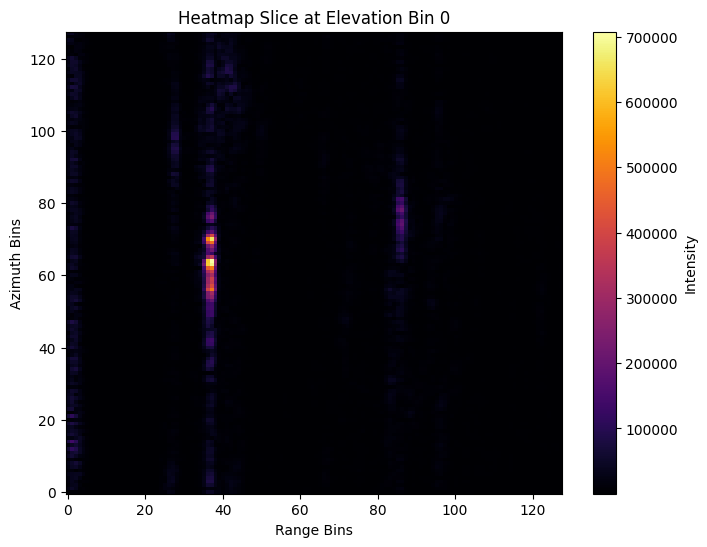

In [10]:
show_flat_heatmap(heatmap_original)

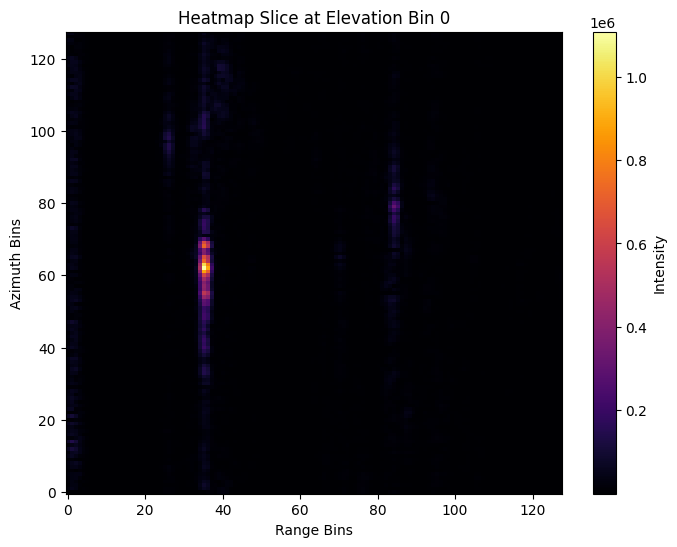

In [11]:
show_flat_heatmap(heatmap_from_datacube)

#### Simple heatmap-to-pointcloud conversion (no CFAR)

In [12]:
heatmap_cloud = radar_config.heatmap_to_pointcloud(heatmap_from_datacube)
heatmap_cloud.shape  # 5 ~ [x, y, z, i, doppler]

(524288, 5)

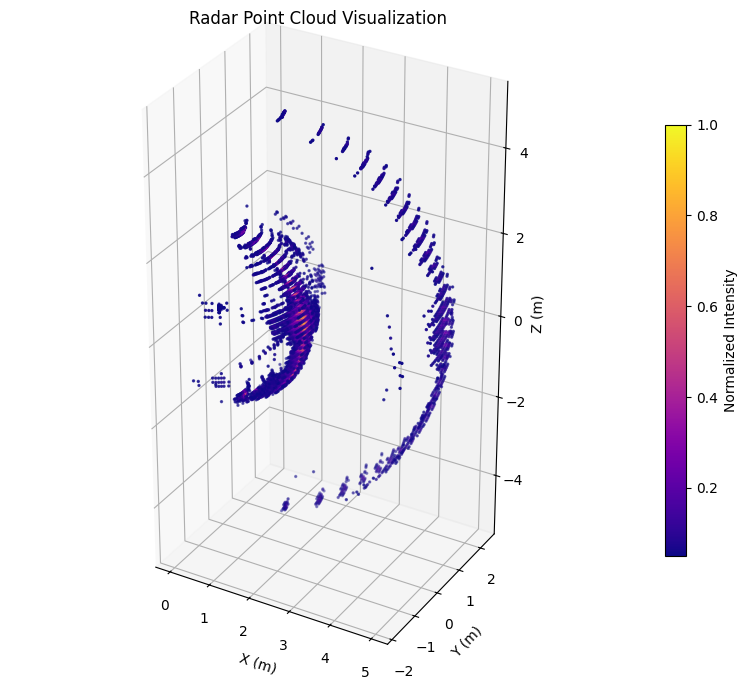

In [33]:
demo.show_radar_pcl(heatmap_cloud, intensity_threshold=0.05)

### Show Radar FOV Options
The indices of these FOV options are referred to by the dataset export feature.

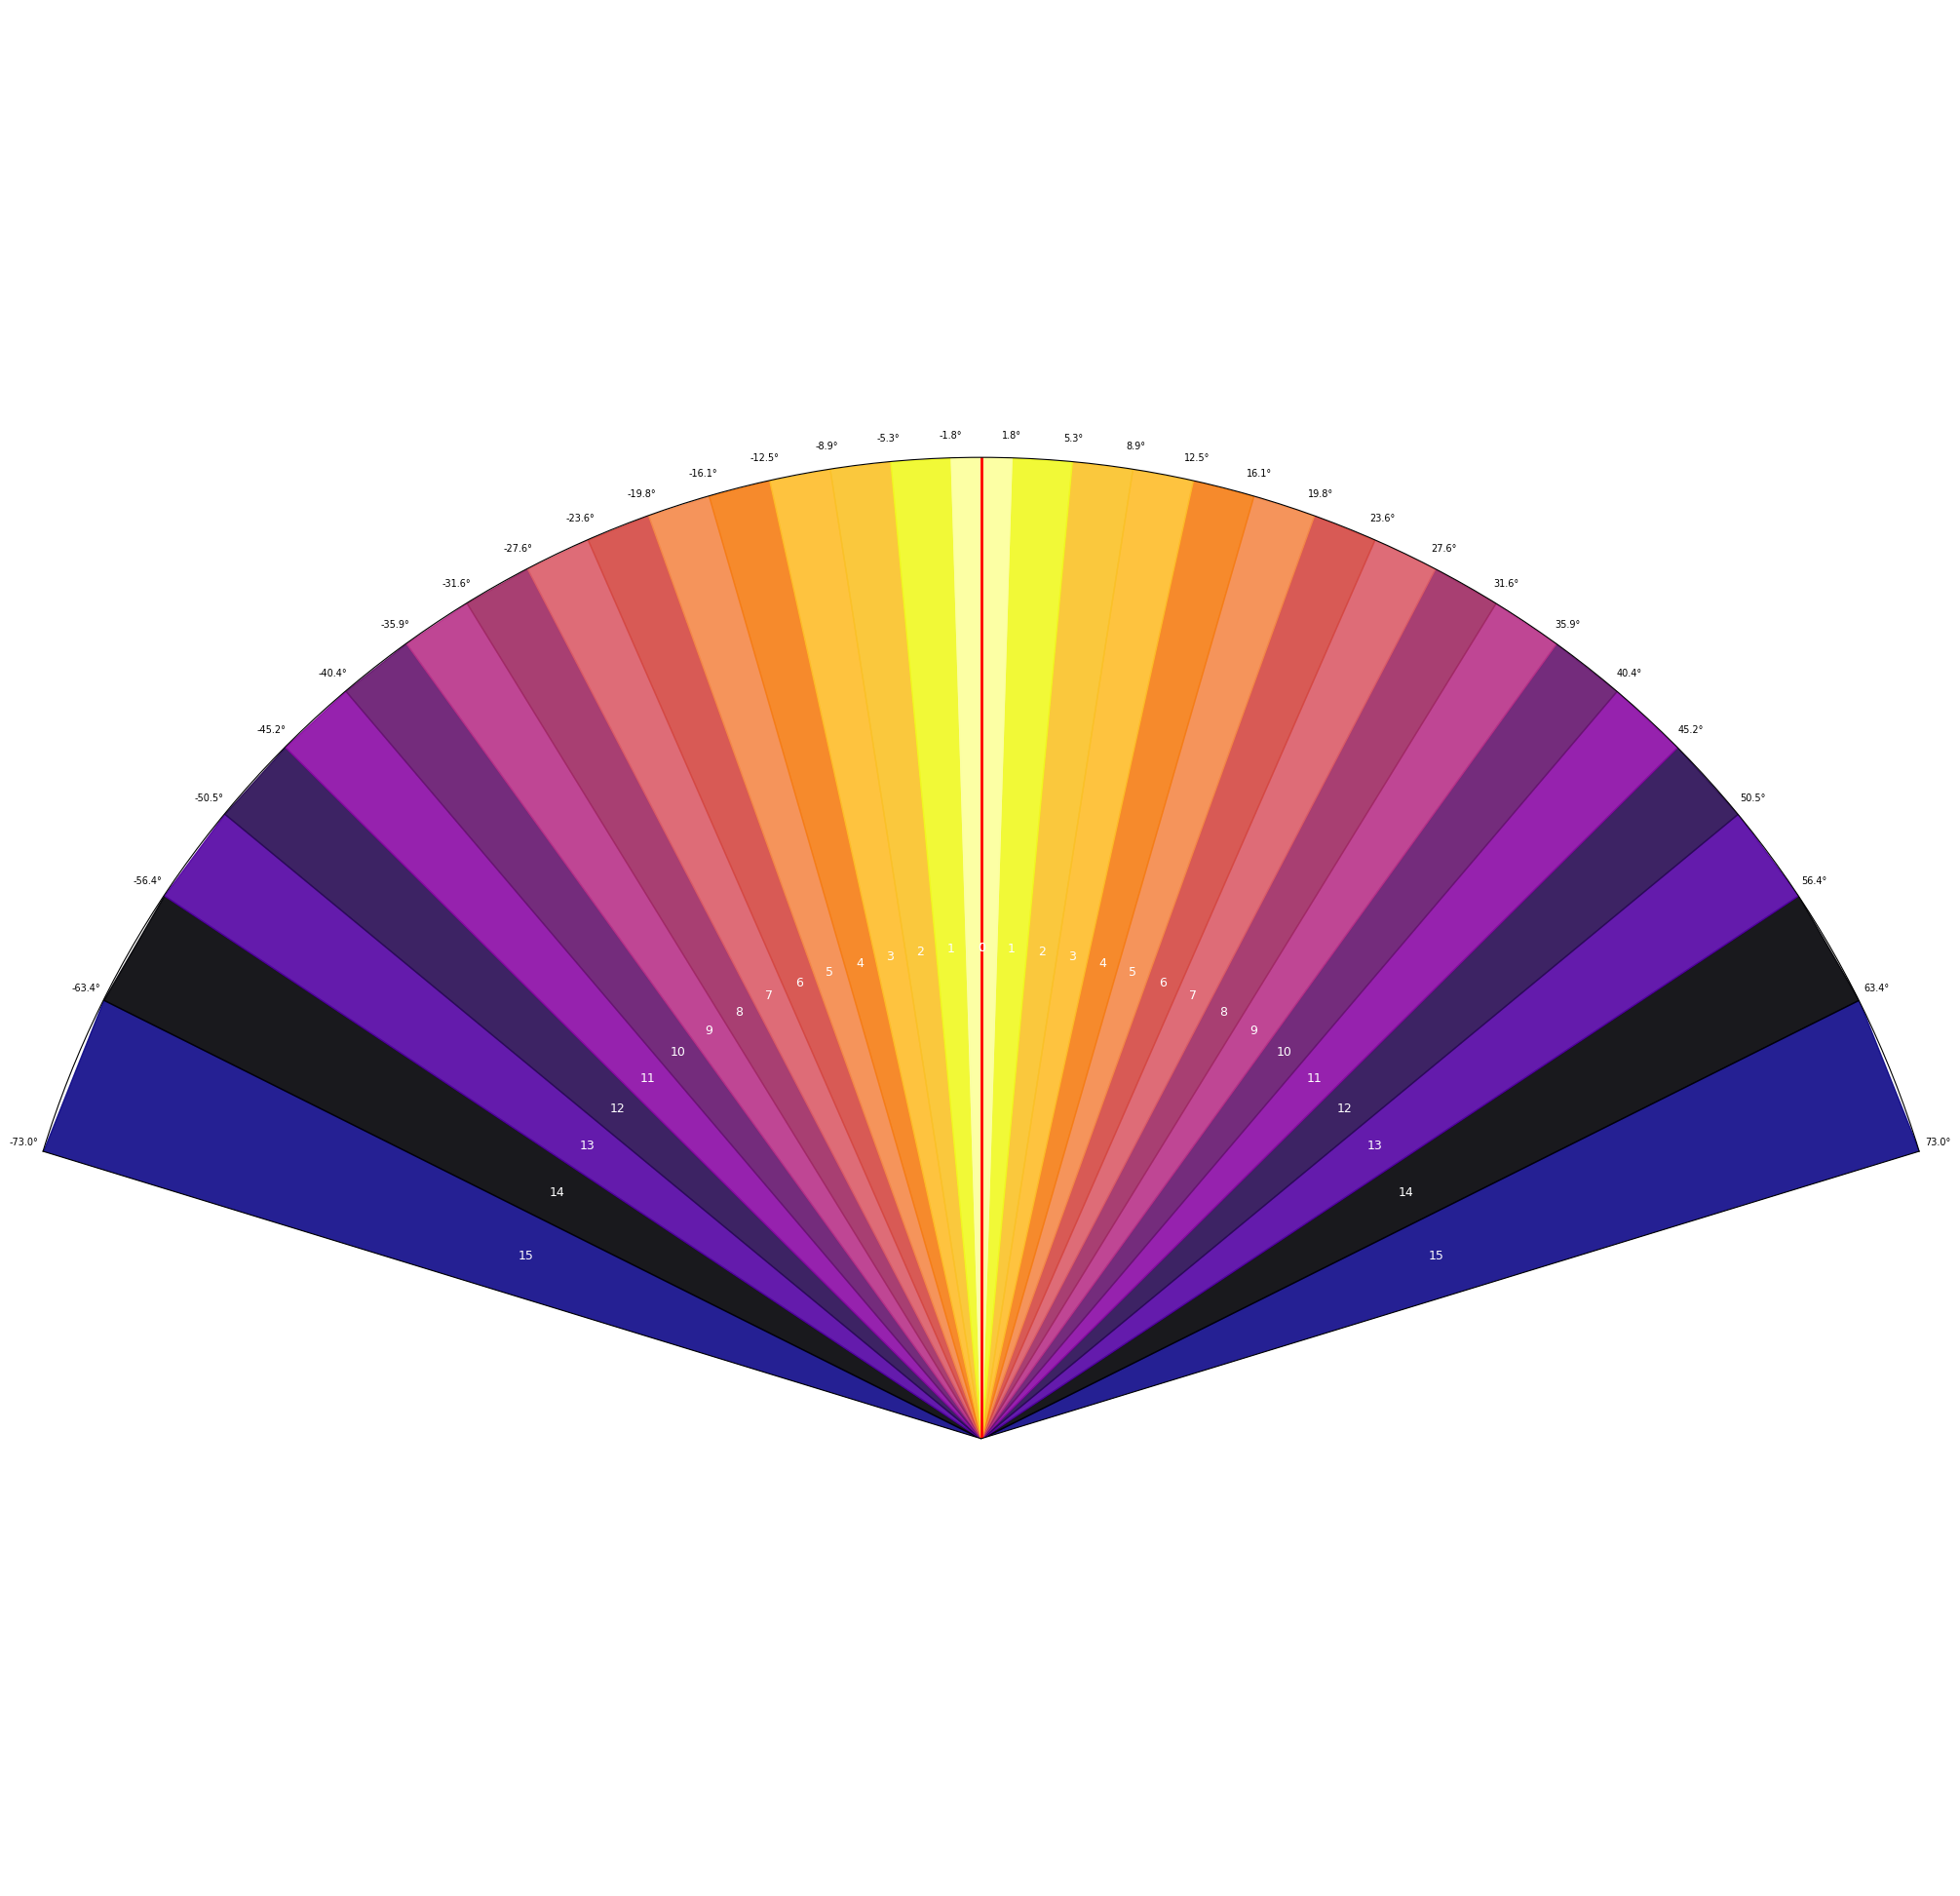

In [22]:
demo.display_elevation_fov_options(radar_config)

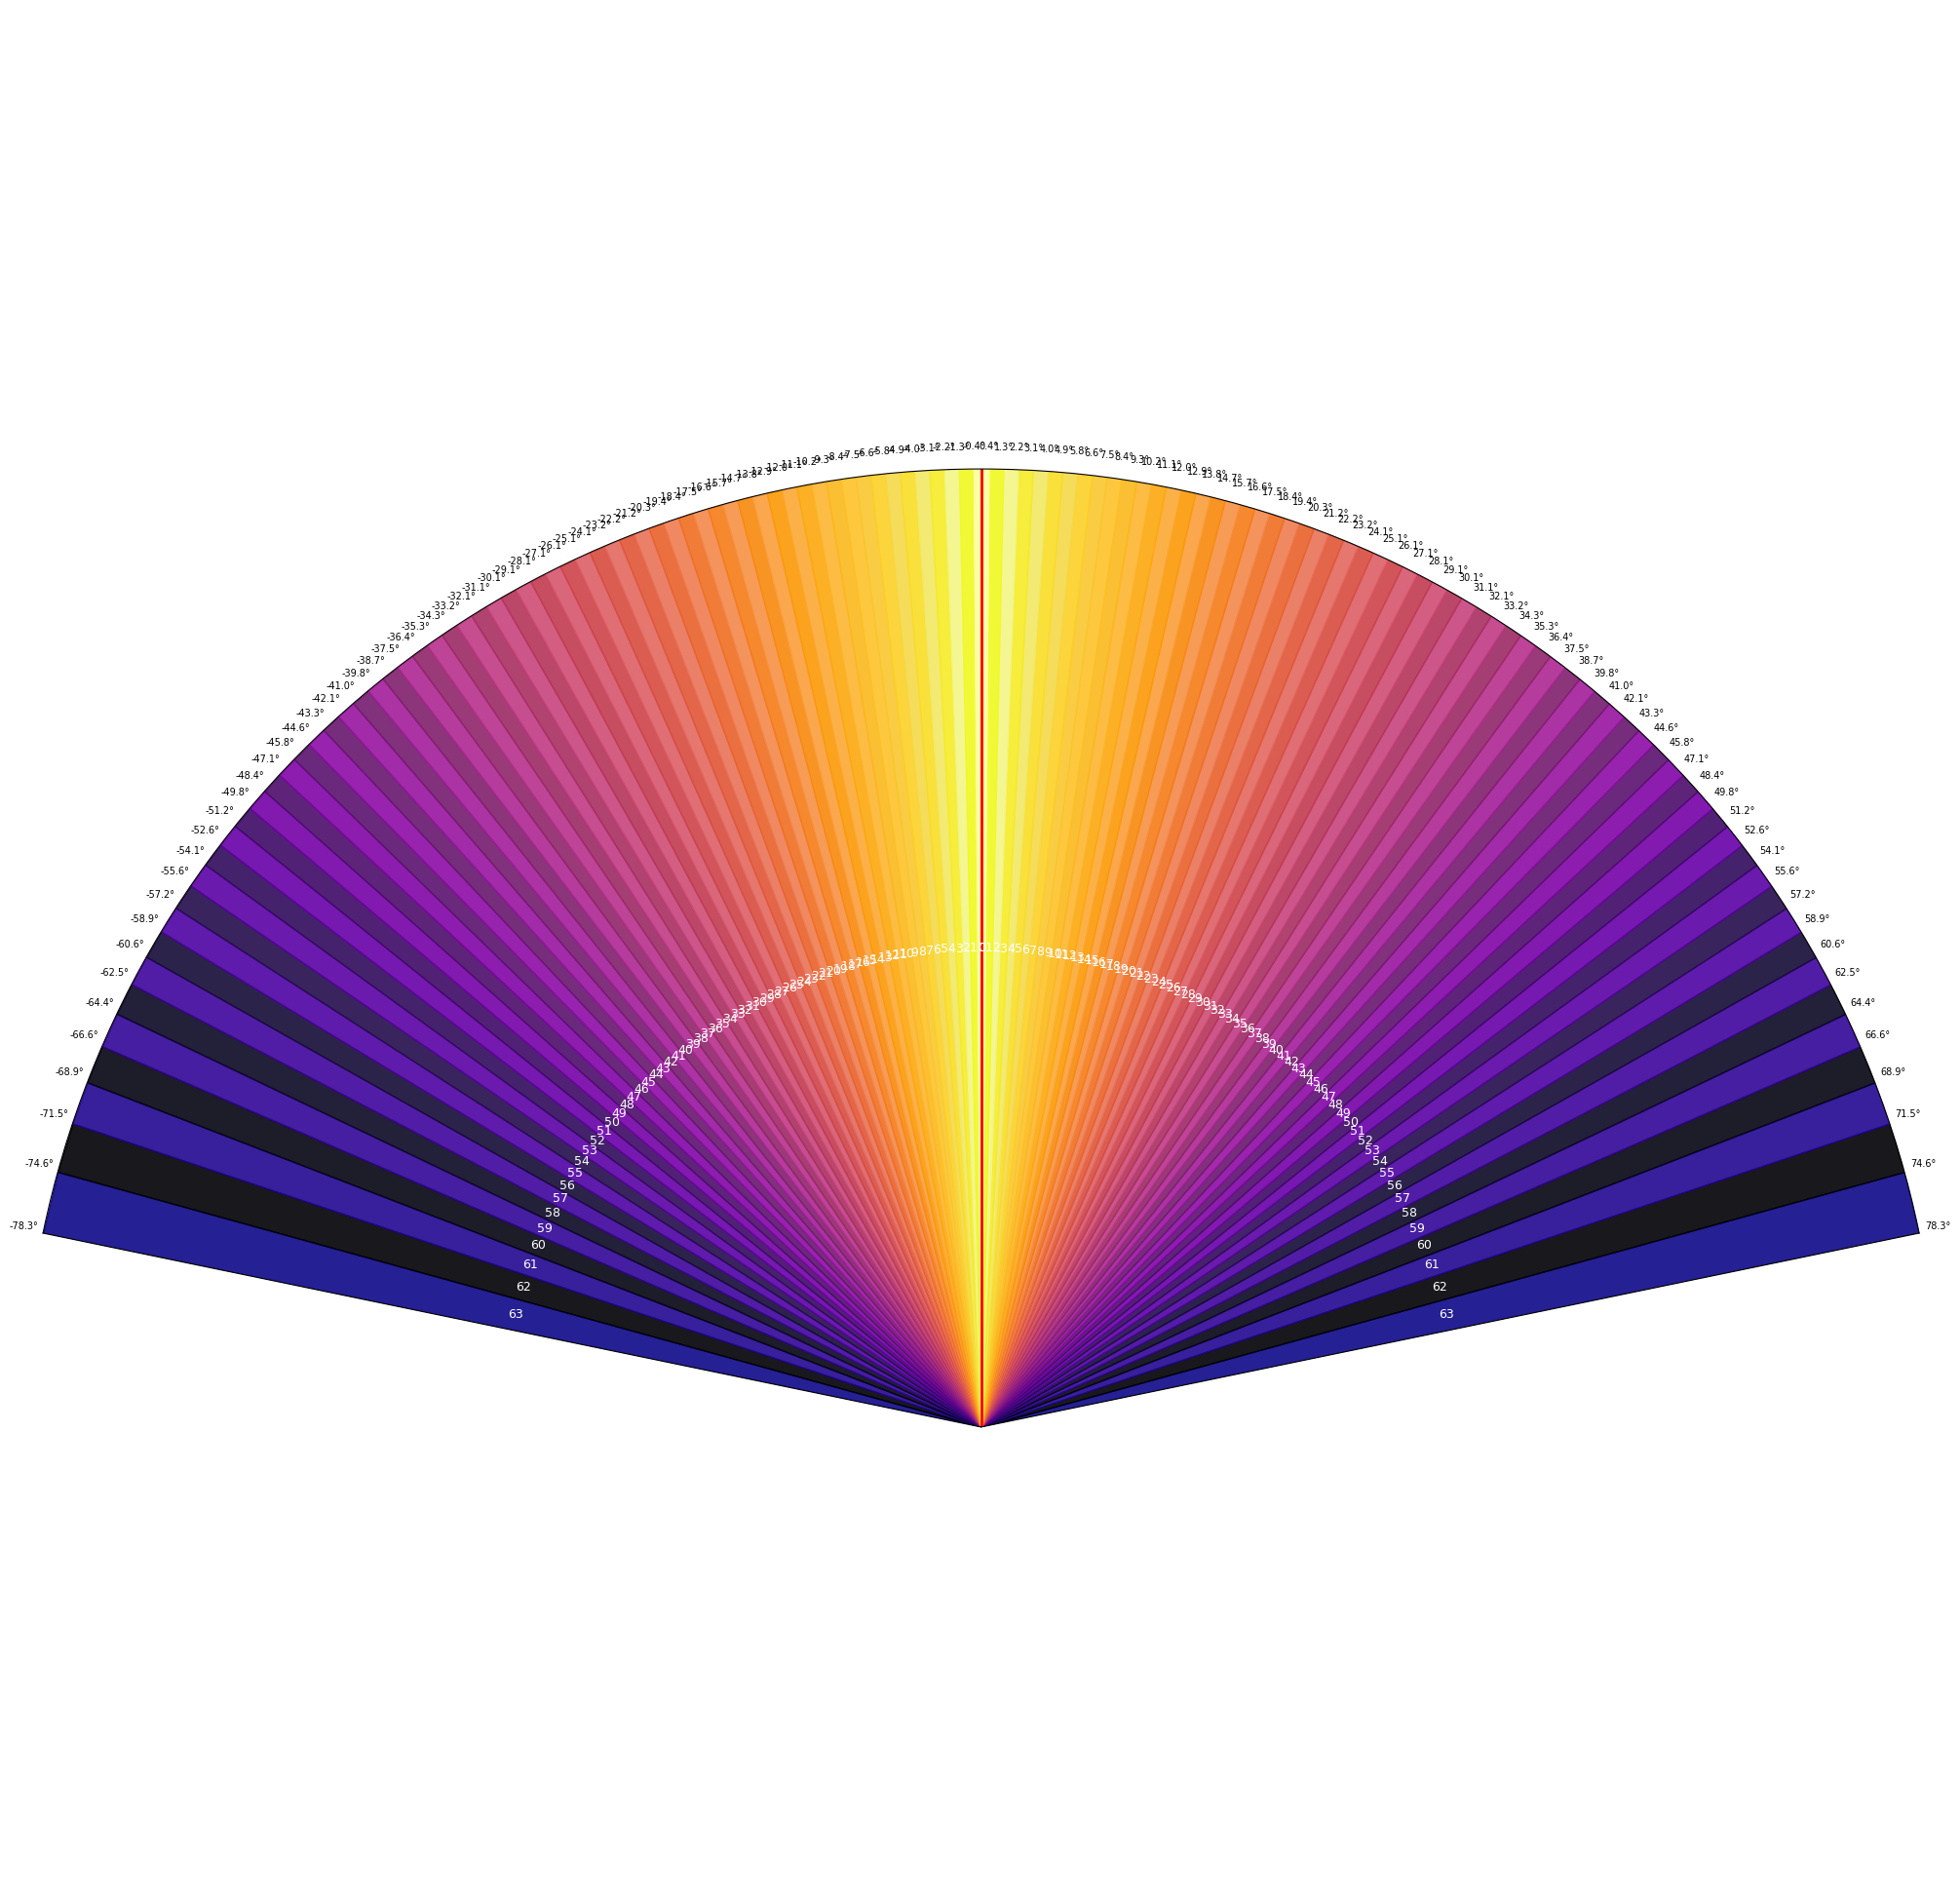

In [20]:
demo.display_azimuth_fov_options(radar_config)

#### Helper functions to convert FOV degrees to bin indices and back

In [23]:
# last bin = full FOV of 156.6 degrees
radar_config.azimuth_idx_to_fov_degrees(63)

156.64476013183594

In [28]:
# bin number 4 corresponds to the elevation FOV of 32.2 degrees (or from -16.1 to 16.1 degrees in the picture)
radar_config.elevation_idx_to_fov_degrees(4)

32.233726501464844

In [24]:
# 128 range bins total were used in this dataset
radar_config.n_range_bins()

128

In [25]:
# last range bin corresponds to max distance
radar_config.range_idx_to_range(127)

7.589682579040527

In [26]:
# the range of 7 meters corresponds to range bin number 118
radar_config.range_to_range_idx(7)

118

### Plot trajectory

In [29]:
true_timestamps = run.pose_timestamps()
radar_timestamps = run.cascade_timestamps()
true_timestamps.shape, radar_timestamps.shape

((290,), (1396,))

In [31]:
# poses are arrays of (x, y, z, qx, qy, qz, qw)
true_poses = run.get_poses()
radar_poses = ct.interpolate_poses(true_poses, true_timestamps, radar_timestamps)
true_poses.shape, radar_poses.shape

((290, 7), (1396, 7))

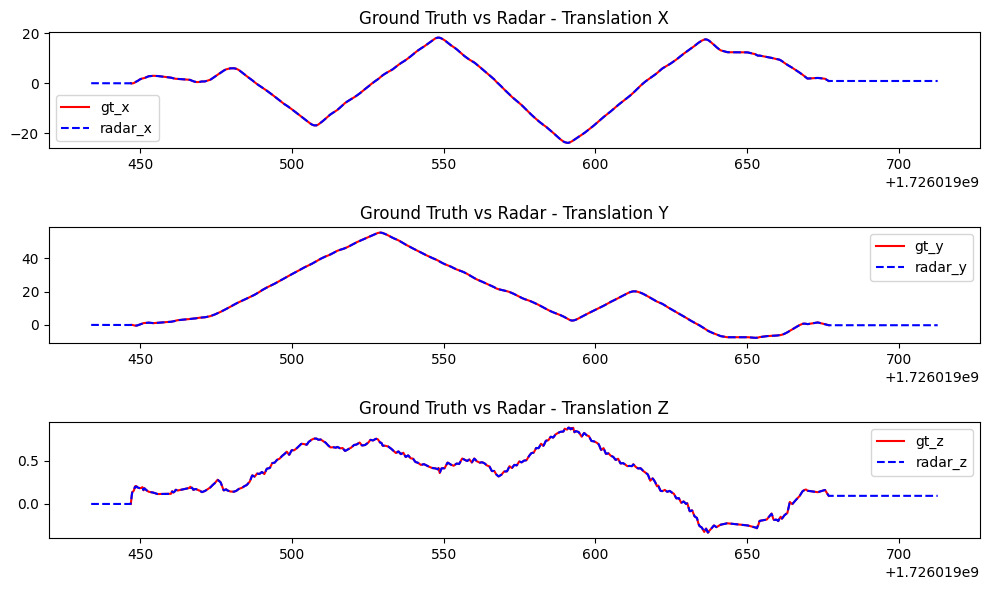

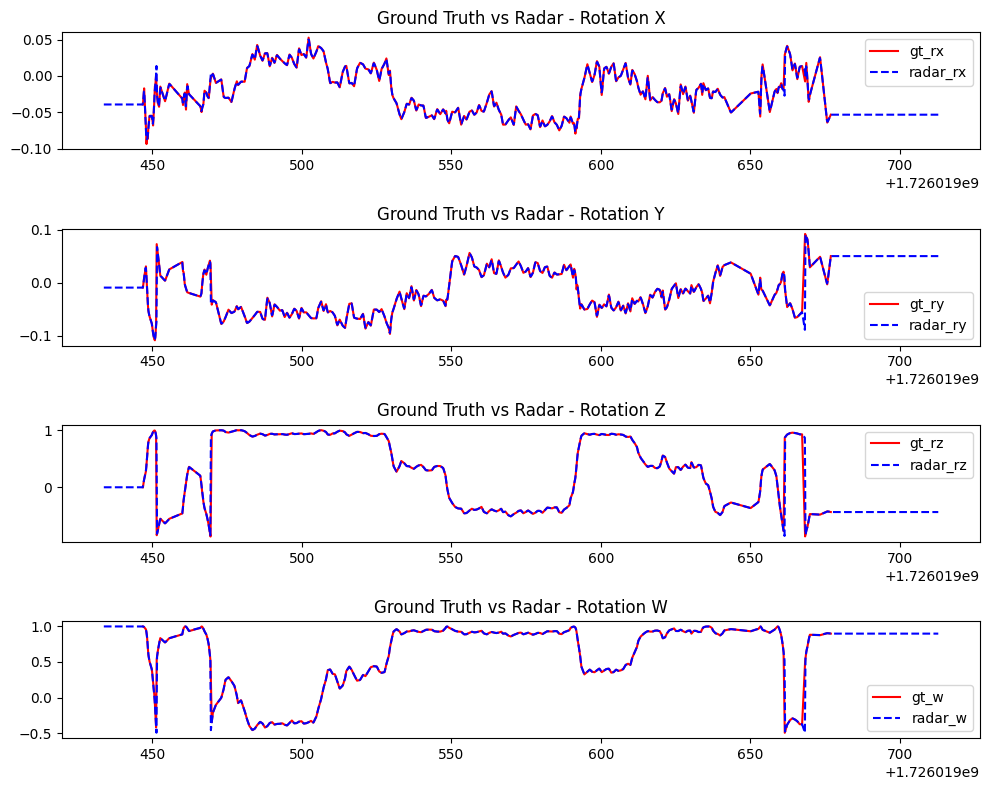

In [32]:
demo.plot_poses(true_timestamps, true_poses, radar_timestamps, radar_poses, 'radar')